# Airline Review Sentiment Project 

In [1]:
#!pip install keras

import numpy as np
import pandas as pd
import tensorflow as tf
import re

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

import utils as utl
from collections import Counter

from tensorflow.keras.preprocessing.text import Tokenizer #Change made here to import Tokenizer from tensorflow.keras.preprocessing.text
from tensorflow.keras.preprocessing.sequence import pad_sequences #Change made here to import pad_sequences from tensorflow.keras.preprocessing.sequence
from tensorflow.keras.utils import to_categorical #Change made here to import to_categorical from tensorflow.keras.utils

from tensorflow.keras.layers import Dense, Input, Flatten, Dropout#, Merge #Change made here to import from tensorflow.keras.layers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding #Change made here to import from tensorflow.keras.layers
from tensorflow.keras.models import Model

/Users/langleyburke/Airline Sentiment Analysis Files  2/utils.py:15: SyntaxWarning: invalid escape sequence '\$'
  REGEX_TICKER = re.compile('\$[a-zA-Z]+')
/Users/langleyburke/Airline Sentiment Analysis Files  2/utils.py:16: SyntaxWarning: invalid escape sequence '\@'
  REGEX_USER = re.compile('\@\w+')
/Users/langleyburke/Airline Sentiment Analysis Files  2/utils.py:17: SyntaxWarning: invalid escape sequence '\/'
  REGEX_LINK = re.compile('https?:\/\/[^\s]+')
/Users/langleyburke/Airline Sentiment Analysis Files  2/utils.py:18: SyntaxWarning: invalid escape sequence '\&'
  REGEX_HTML_ENTITY = re.compile('\&\w+')


## Processing Data

#### Read and View Data

First we simply read in our data using pandas, pull out our message and sentiment data into numpy arrays. We'll also take a look at a few samples to get familiar with the data set.

In [8]:
import os 

#Use this to change directory if files are in a folder. 
os.chdir('/Users/langleyburke/Airline Sentiment Analysis Files ')

print("Current Working Directory:", os.getcwd())


Current Working Directory: /Users/langleyburke/Airline Sentiment Analysis Files  2


In [10]:
# read data from csv file
review_data = pd.read_csv("updated_Airline_review1.csv", encoding="utf-8")

review_data.head()

,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,...,Recommended,recommended_numeric,from_city,to_city,from_coords,to_coords,from_lat,from_lon,to_lat,to_lon
0,AB Aviation,9.0,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,Moroni to Moheli,...,Yes,1,Moroni,Moheli,"(-11.6931255, 43.2543044)","(-12.32045735, 43.720431326729724)",-11.693126,43.254304,-12.320457,43.720431
1,AB Aviation,1.0,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,Moroni to Anjouan,...,No,0,Moroni,Anjouan,"(-11.6931255, 43.2543044)","(-12.226568050000001, 44.41070486098224)",-11.693126,43.254304,-12.226568,44.410705
2,AB Aviation,1.0,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,...,No,0,Anjouan,Dzaoudzi,"(-12.226568050000001, 44.41070486098224)","(-12.782151, 45.2556923)",-12.226568,44.410705,-12.782151,45.255692
3,Adria Airways,1.0,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,NaN,Solo Leisure,Economy Class,Frankfurt to Pristina,...,No,0,Frankfurt,Pristina,"(50.1106444, 8.6820917)","(42.6638771, 21.1640849)",50.110644,8.682092,42.663877,21.164085
4,Adria Airways,1.0,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,NaN,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,...,No,0,Sofia,Amsterdam,"(42.6977028, 23.3217359)","(None, None)",42.697703,23.321736,NaN,NaN


In [8]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23140 entries, 0 to 23139
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Airline Name            23140 non-null  object 
 1   Overall_Rating          22298 non-null  float64
 2   Review_Title            23140 non-null  object 
 3   Review Date             23140 non-null  object 
 4   Verified                23140 non-null  bool   
 5   Review                  23140 non-null  object 
 6   Aircraft                7122 non-null   object 
 7   Type Of Traveller       19402 non-null  object 
 8   Seat Type               22044 non-null  object 
 9   Route                   19312 non-null  object 
 10  Date Flown              19387 non-null  object 
 11  Seat Comfort            18990 non-null  float64
 12  Cabin Staff Service     18885 non-null  float64
 13  Food & Beverages        14488 non-null  float64
 14  Ground Service          18350 non-null

## Cleaning

In [49]:
#If reading in data from Kaggle - but need to run geo too to get coordinates if doing so (Takes two hours so will give the updated data) 

# Convert the 'Route' column to strings, replacing NaN with an empty string
#review_data_original["Route"] = review_data_original["Route"].fillna("").astype(str)

# Function to extract 'from' and 'to' cities
#def extract_from_to(route):
    #match = re.search(r"(?i)(\w[\w\s]+)\s+to\s+(\w[\w\s]+)", route)
    #if match:
      #  return match.group(1).strip(), match.group(2).strip()
    #return None, None

# Apply the function to the Route column
#review_data_original[["from_city", "to_city"]] = review_data_original["Route"].apply(lambda x: pd.Series(extract_from_to(x)))

# Display the updated data
#review_data_original.head()

In [12]:
review_data['Recommended'] = review_data['Recommended'].replace({'yes': 'Yes', 'no': 'No'})

In [14]:
# Function to extract the first word (city)
def clean_city_name(city_name):
    if isinstance(city_name, str):  # Ensure the value is a string
        return city_name.split(" via")[0]  # Split by space and take the first word
    return city_name  # Return the value as is if not a string

# Apply the function to 'from_city' and 'to_city' columns
review_data['from_city'] = review_data['from_city'].apply(clean_city_name)
review_data['to_city'] = review_data['to_city'].apply(clean_city_name)

# Display the cleaned columns
print(review_data[['from_city', 'to_city']].head())

   from_city    to_city
0     Moroni     Moheli
1     Moroni    Anjouan
2    Anjouan   Dzaoudzi
3  Frankfurt   Pristina
4      Sofia  Amsterdam


In [16]:
# Assuming your DataFrame is filtered_df and the city column is named 'City'

# Filter the rows where 'City' includes "Boston"
boston_cities = review_data[review_data['to_city'].str.contains("Boston", case=False, na=False)]

un_boston_cities = boston_cities['to_city'].unique()

print(un_boston_cities)


['Boston']


In [18]:
# Filter cities with exactly three letters
three_letter_cities = review_data['to_city'].dropna()  # Remove NaN values
three_letter_cities = three_letter_cities[three_letter_cities.str.match(r'^[A-Za-z]{3}$')]

# Display the results
print(three_letter_cities)

742      Fez
795      Fes
797      Fez
805      Fez
806      Fez
        ... 
21942    Goa
21953    Goa
21994    Goa
22014    Goa
22671    Lop
Name: to_city, Length: 90, dtype: object


In [20]:
import pandas as pd

# Step 1: Load the airport codes and city names dataset
# Assuming 'airport_df' contains the airport codes and city names
airport_code_df = pd.read_csv('Airport Codes.csv')  # Update with the correct file path

# Step 2: Create a mapping dictionary from airport codes to city names
airport_mapping = dict(zip(airport_code_df['Airport Code'], airport_code_df['City Name']))

# Step 2: Replace 3-letter codes in 'to_city' and 'from_city' columns
def replace_airport_code_with_city(city):
    # Handle NaN values by checking if the city is a valid string with length
    if isinstance(city, str) and len(city) == 3 and city in airport_mapping:
        return airport_mapping[city]  # Replace with city name
    return city  # 
    
# Apply the replacement function to both 'to_city' and 'from_city'
review_data['to_city'] = review_data['to_city'].apply(replace_airport_code_with_city)
review_data['from_city'] = review_data['from_city'].apply(replace_airport_code_with_city)


In [22]:
# Apply title case to both 'to_city' and 'from_city' columns
review_data['to_city'] = review_data['to_city'].apply(lambda city: city.title() if isinstance(city, str) else city)
review_data['from_city'] = review_data['from_city'].apply(lambda city: city.title() if isinstance(city, str) else city)

In [24]:
import pandas as pd
from unidecode import unidecode

# Remove accents from the city names
review_data['to_city'] = review_data['to_city'].apply(lambda city: unidecode(city) if isinstance(city, str) else city)
review_data['from_city'] = review_data['from_city'].apply(lambda city: unidecode(city) if isinstance(city, str) else city)


In [26]:
# Remove rows where city name is 'Co', 'Ca', or 'St' in either to_city or from_city
review_data = review_data[~review_data['to_city'].isin(['Co', 'Ca', 'St']) & ~review_data['from_city'].isin(['Co', 'Ca', 'St'])]

In [28]:
# List of city substrings to be replaced with their full names
city_replacements = {
    'Lauderdale': 'Fort Lauderdale',
    'Boston': 'Boston',     
    'Francisco': 'San Francisco',
    'Houston': 'Houston',
    'Washington': 'Washington',
    'London': 'London',
    'Atlanta': 'Atlanta',
    'Milwaukee': 'Milwaukee',
    'Chicago': 'Chicago',
    'Sacramento': 'Sacramento',
    'Orlando': 'Orlando',
    'Dallas': 'Dallas',
    'New York': 'New York'
}

# Function to clean city names based on whether the city contains any of the keywords in city_replacements
def clean_city_name(city):
    if isinstance(city, str):
        for key, replacement in city_replacements.items():
            if key in city:
                return replacement
    return city

# Apply the function to both 'to_city' and 'from_city'
review_data['to_city'] = review_data['to_city'].apply(clean_city_name)
review_data['from_city'] = review_data['from_city'].apply(clean_city_name)

    

In [30]:
#from geopy.geocoders import Nominatim
#import pandas as pd
#from tqdm import tqdm

# Initialize the geocoder
#geolocator = Nominatim(user_agent="city_mapper")

# Get a list of unique cities
#unique_cities = pd.concat([review_data['from_city'], review_data['to_city']]).unique()


# Dictionary to cache results
#geo_cache = {}

# Function to get coordinates with caching
#def get_coordinates_cached(city):
    #if not city:  # Skip empty or None values
        #return None, None
    #if city in geo_cache:  # Return cached result
        #return geo_cache[city]
    #try:
        #location = geolocator.geocode(city, timeout=10)
        #if location:
           # coords = (location.latitude, location.longitude)
          #  geo_cache[city] = coords  # Cache the result
         #   return coords
   # except Exception as e:
    #    print(f"Error fetching coordinates for {city}: {e}")
   # geo_cache[city] = (None, None)  # Cache failure
   # return None, None

# Use tqdm to create a progress bar in the console
#for city in tqdm(unique_cities, desc="Geocoding cities"):
    #get_coordinates(city)

# Geocode all unique cities
#city_coords = {city: get_coordinates(city) for city in unique_cities}

# Create a new column in the dataframe for lat/lon for 'from_city' and 'to_city'
#review_data['from_coords'] = review_data['from_city'].apply(lambda city: city_coords.get(city, (None, None)))
#review_data['to_coords'] = review_data['to_city'].apply(lambda city: city_coords.get(city, (None, None)))

# Separate latitude and longitude into separate columns
#review_data[['from_lat', 'from_lon']] = pd.DataFrame(review_data['from_coords'].to_list(), index=review_data.index)
#review_data[['to_lat', 'to_lon']] = pd.DataFrame(review_data['to_coords'].to_list(), index=review_data.index)

# View the updated dataframe
#review_data.head()

In [32]:
review_data['recommended_numeric'] = review_data['Recommended'].apply(lambda x: 1 if x == 'Yes' else 0)

In [34]:
review_data.to_csv('updated_Airline_review1.csv', index=False)

# Display the first few rows of the dataframe to confirm
print(review_data.head())

    Airline Name  Overall_Rating                           Review_Title  \
0    AB Aviation             9.0                "pretty decent airline"   
1    AB Aviation             1.0                   "Not a good airline"   
2    AB Aviation             1.0         "flight was fortunately short"   
3  Adria Airways             1.0    "I will never fly again with Adria"   
4  Adria Airways             1.0  "it ruined our last days of holidays"   

           Review Date  Verified  \
0   11th November 2019      True   
1       25th June 2019      True   
2       25th June 2019      True   
3  28th September 2019     False   
4  24th September 2019      True   

                                              Review       Aircraft  \
0    Moroni to Moheli. Turned out to be a pretty ...            NaN   
1   Moroni to Anjouan. It is a very small airline...           E120   
2    Anjouan to Dzaoudzi. A very small airline an...  Embraer E120    
3    Please do a favor yourself and do not fly w

In [36]:
# Convert 'rating' to numeric
review_data['Overall_Rating'] = pd.to_numeric(review_data['Overall_Rating'], errors='coerce')  

## Sentiment Review Exploring 

In [38]:
# Summary for categorical columns
sentiment_counts = review_data['Recommended'].value_counts()

# Show counts for sentiment labels
print("Sentiment Counts:")
print(sentiment_counts)


Sentiment Counts:
Recommended
No     15339
Yes     7801
Name: count, dtype: int64


In [32]:
# Calculate length of each review
review_data['Review_Length'] = review_data['Review'].apply(len)

# Get a textual summary of the reviews
average_review_length = review_data['Review_Length'].mean()
max_review_length = review_data['Review_Length'].max()

# Display textual summary
print(f"Average Review Length: {average_review_length} characters")
print(f"Max Review Length: {max_review_length} characters")

Average Review Length: 721.8709161624892 characters
Max Review Length: 5080 characters


In [34]:
# Optionally, you can check for the most frequent words (word cloud or frequency count)
from collections import Counter
import re

# Combine all reviews into one large string
all_reviews = ' '.join(review_data['Review'].dropna())

# Remove non-alphanumeric characters and split into words
words = re.findall(r'\b\w+\b', all_reviews.lower())

# Get the 10 most common words
word_counts = Counter(words).most_common(10)

# Display most common words
print("Top 10 most common words in reviews:")
for word, count in word_counts:
    print(f"{word}: {count}")


Top 10 most common words in reviews:
the: 142345
to: 109399
and: 90457
i: 67408
a: 60511
was: 59899
in: 45380
flight: 43117
for: 37577
of: 37491


In [36]:
#get messages and sentiment labels
reviews = review_data.Review.values
labels = review_data.Recommended.values

for i in range(10):
    print("Messages: {}...".format(reviews[i]),
          "Sentiment: {}".format(labels[i]))

Messages:   Moroni to Moheli. Turned out to be a pretty decent airline. Online booking worked well, checkin and boarding was fine and the plane looked well maintained. Its a very short flight - just 20 minutes or so so i didn't expect much but they still managed to hand our a bottle of water and some biscuits which i though was very nice. Both flights on time.... Sentiment: yes
Messages:  Moroni to Anjouan. It is a very small airline. My ticket advised me to turn up at 0800hrs which I did. There was confusion at this small airport. I was then directed to the office of AB Aviation which was still closed. It opened at 0900hrs and I was told that the flight had been put back to 1300hrs and that they had tried to contact me. This could not be true as they did not have my phone number. I was with a local guide and he had not been informed either. I presume that I was bumped off. The later flight did operate but as usual, there was confusion at check-in. The flight was only 30mins and there 

#### Check Reviews Lengths

In [71]:
review_lens = Counter([len(x) for x in reviews])
print("Zero-length messages: {}".format(review_lens[0]))
print("Maximum message length: {}".format(max(review_lens)))
print("Average message length: {}".format(np.mean([len(x) for x in reviews])))

Zero-length messages: 0
Maximum message length: 5080
Average message length: 721.8190842000777


In [73]:
reviews, labels = utl.drop_empty_messages(reviews, labels)

#### Preprocess Reviews

Want to normalize for known unique words that appear within reviews that carry a similar contextual meaning when analyzing sentiment. 

In [77]:
reviews = np.array([utl.preprocess_ST_message(Review) for Review in reviews])

#### Generate Vocab to Index Mapping

Use a Keras `Tokenizer` in order to generate the word index. The tockenizer takes the vocabulary and assigns each word a unique index from 1 to *VOCAB_SIZE*. Zero is reserved for padding.

In [107]:
VOCAB = sorted(list(set(reviews)))
VOCAB_SIZE = len(VOCAB)
print(VOCAB_SIZE)

23043


In [40]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(reviews)

In [42]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 35253 unique tokens.


In [180]:
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as json_file:
    json.dump(tokenizer_json, json_file)


In [46]:
for word, i in word_index.items():
    if i > 10:
        break
    print(str(i) + ' - ' + word)
    

1 - the
2 - to
3 - and
4 - number
5 - i
6 - a
7 - was
8 - flight
9 - in
10 - for


#### Encode Reviews and Labels

In [50]:
sequences = tokenizer.texts_to_sequences(reviews)

In [52]:
labels = to_categorical(utl.encode_ST_labels(labels))

In [54]:
print("Unique values in labels:", np.unique(labels))

Unique values in labels: [0. 1.]


#### Pad Reviews

In [58]:
MAX_SEQUENCE_LENGTH = 750
review_data_new = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [60]:
review_data_new

array([[    0,     0,     0, ...,    56,    12,    35],
       [    0,     0,     0, ...,    47,    10, 10973],
       [    0,     0,     0, ...,     7,   250,   186],
       ...,
       [    0,     0,     0, ...,   227,     2,   371],
       [    0,     0,     0, ...,   108,   457,    17],
       [    0,     0,     0, ...,    13,    23,    33]], dtype=int32)

#### Train and Validation Split

The last thing we do is split our data into tranining and validation sets.

In [64]:
VALIDATION_SPLIT = .2
num_validation_samples = int(VALIDATION_SPLIT * review_data_new.shape[0])

In [66]:
indices = np.arange(review_data_new.shape[0])
np.random.shuffle(indices)
review_data_new = review_data_new[indices]
labels = labels[indices]

In [68]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    review_data_new,
    labels,
    test_size=num_validation_samples / len(labels),
    stratify=labels,  # Ensures both 0 and 1 are included proportionally
    random_state=42   # For reproducibility
)

# Check unique values and counts in training and validation labels
print("Training set label distribution:", np.unique(y_train, return_counts=True))
print("Validation set label distribution:", np.unique(y_val, return_counts=True))


Training set label distribution: (array([0., 1.]), array([18537, 18537]))
Validation set label distribution: (array([0., 1.]), array([4634, 4634]))


## Building and Training the CNN Network

In this section we will load our pretrained word embeddings and build out CNN Model.

#### Glove Embeddings

For this example we will use the wikipedia and giga word 5 GloVe embeddings that can be found at the liink https://nlp.stanford.edu/projects/glove/. We have our embeddings saved in a text file in our data directory so first we load parse these and load them in to a dictionary.

In [74]:
EMBEDDING_DIM = 50
EMBEDDING_FILE = 'Airline Sentiment Analysis Files /glove.6B.50d.txt'

def get_embed_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

In [76]:
embeddings_index = dict(get_embed_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE,  encoding="utf8"))

In [78]:
embeddings_values=list(embeddings_index.values())
all_embs = np.stack(embeddings_values)
emb_mean,emb_std = all_embs.mean(), all_embs.std()

In [80]:
embedding_matrix = np.random.normal(emb_mean, emb_std, (len(word_index) + 1, EMBEDDING_DIM))

In [82]:
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
    if i < 10:
        print(word + ' - ' + str(len(embedding_vector)) + ' - ' + str(embedding_vector))

the - 50 - [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]
to - 50 - [ 0.68047  -0.039263  0.30186  -0.17792   0.42962   0.032246 -0.41376
  0.13228  -0.29847  -0.085253  0.17118   0.22419  -0.10046  -0.43653
  0.33418   0.67846   0.057204 -0.34448  -0.42785  -0.43275   0.55963
  0.10032   0.18677  -0.26854   0.037334 -2.0932    0.22171  -0.39868
  0.20912  -0.55725   3.8826    0.47466  -0.95658  -0.37788   0.20869
 -0.32752   0.12751

In [84]:
embedding_matrix.shape

(35254, 50)

In [86]:
from keras.layers import Concatenate, Average   

#### Model and Training

Here we build the Convoluational Neural Network using Keras. We will use the architecture from the Yoon Kim model (https://arxiv.org/abs/1408.5882) with some adjustments. 

In [121]:
from keras.layers import GlobalMaxPooling1D


def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    embedding_layer = Embedding(num_words,
                                embedding_dim,
                                weights=[embeddings],
                                input_length=max_sequence_length,
                                trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3, 5, 10, 30]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        # Use GlobalMaxPooling1D to avoid size mismatch issues
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)

    # Concatenate all the pooled results along axis 1 (features)
    l_merge = Concatenate(axis=1)(convs)

    # Optional additional convolutional layer with pooling
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)
    
    if extra_conv:
        x = Dropout(0.5)(l_merge)  # Use merged layers after global pooling
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
        
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model


In [123]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [125]:
model = ConvNet(embedding_matrix, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                len(labels[0]), False)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [128]:
train = model.fit(x_train, y_train,
                    epochs=10,
                    verbose=2,
                    validation_data=(x_val, y_val),
                    batch_size=10)
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))



Epoch 1/10
1854/1854 - 50s - 27ms/step - acc: 0.8168 - loss: 0.4163 - val_acc: 0.8874 - val_loss: 0.2855
Epoch 2/10
1854/1854 - 49s - 27ms/step - acc: 0.8757 - loss: 0.3056 - val_acc: 0.8863 - val_loss: 0.2898
Epoch 3/10
1854/1854 - 49s - 27ms/step - acc: 0.8878 - loss: 0.2781 - val_acc: 0.8936 - val_loss: 0.2731
Epoch 4/10
1854/1854 - 50s - 27ms/step - acc: 0.8982 - loss: 0.2549 - val_acc: 0.8947 - val_loss: 0.2594
Epoch 5/10
1854/1854 - 50s - 27ms/step - acc: 0.9075 - loss: 0.2295 - val_acc: 0.8940 - val_loss: 0.2597
Epoch 6/10
1854/1854 - 50s - 27ms/step - acc: 0.9147 - loss: 0.2075 - val_acc: 0.8869 - val_loss: 0.2713
Epoch 7/10
1854/1854 - 49s - 27ms/step - acc: 0.9287 - loss: 0.1796 - val_acc: 0.8990 - val_loss: 0.2503
Epoch 8/10
1854/1854 - 50s - 27ms/step - acc: 0.9350 - loss: 0.1590 - val_acc: 0.8886 - val_loss: 0.2877
Epoch 9/10
1854/1854 - 51s - 27ms/step - acc: 0.9469 - loss: 0.1363 - val_acc: 0.8997 - val_loss: 0.2789
Epoch 10/10
1854/1854 - 50s - 27ms/step - acc: 0.9509 -

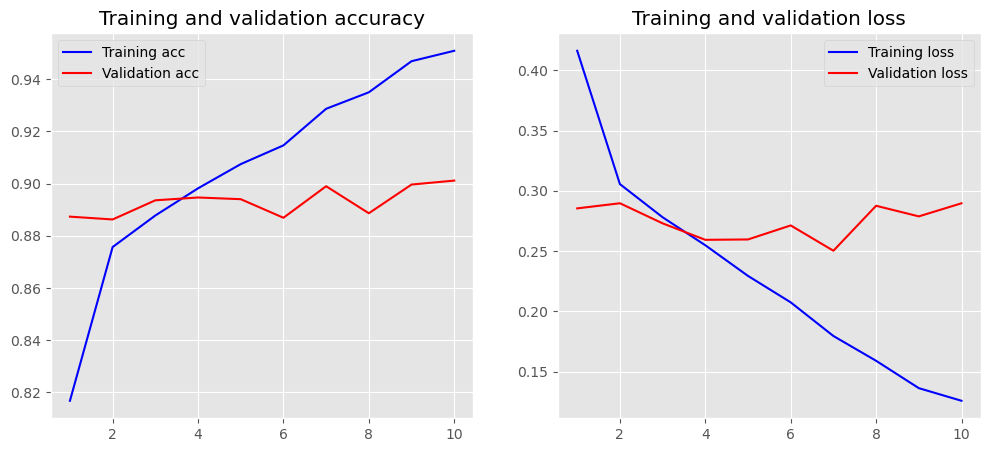

In [130]:
plot_history(train)

In [138]:
# Saving the trained model
model.save('model_new_trained2.h5')  # Save the entire model (architecture + weights)

In [103]:
print(VOCAB_SIZE)

23043


In [134]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 750)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 750, 50)   │  1,762,700 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 748, 128)  │     19,328 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 746, 128)  │     32,128 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 741, 128)  │     64,128 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 721, 128)  │    192,128 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_7[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_8[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_9[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_10[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 512)       │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     65,664 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        258 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,883,604 (11.00 MB)

 Trainable params: 373,634 (1.43 MB)

 Non-trainable params: 1,762,700 (6.72 MB)

 Optimizer params: 747,270 (2.85 MB)

In [75]:
# Make predictions on the validation set
predictions = model.predict(x_val)

# Convert probabilities to binary labels (0 for negative, 1 for positive)
predictions = (predictions > 0.5).astype(int)  # thresholding at 0.5


145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [154]:
train_predictions = model.predict(x_train)  # Predict sentiment for the training set

# If the model outputs probabilities, convert them to binary labels
train_predictions = (train_predictions > 0.5).astype(int)

# If the model's predictions are in the form of probabilities for each class
train_predictions = np.argmax(train_predictions, axis=1)  # Converts to 1D array with 0 or 1


580/580 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [156]:
# Assuming x_data contains the features used to train your model
val_predictions = model.predict(x_val)  # Predict sentiment (0 or 1)

# Optionally, if the model outputs probabilities, convert them to binary labels:
val_predictions = (val_predictions > 0.5).astype(int)

# If the model's predictions are in the form of probabilities for each class
val_predictions = np.argmax(val_predictions, axis=1)  # Converts to 1D array with 0 or 1


# Assuming the training and validation datasets are combined into one dataframe `df`
# You need to concatenate the predictions for both sets
all_predictions = np.concatenate([train_predictions, val_predictions])


review_data['sentiment'] = all_predictions

print(review_data['sentiment'].value_counts())

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
sentiment
0    15546
1     7625
Name: count, dtype: int64
